In [1]:
###########################################################################
# 資料集簡介
#
# 檔案名稱    ： DataSet_Rotation_submean_Normaliation_4cluster.csv 
# 總資料筆數   : 27577筆
# 取樣頻率    ： 每秒30次
# 動作元素分群： 4群
# 標記狀況    : 22855筆 (未標記 transition)
#
# 檔案名稱    ： DataSet_Rotation_submean_Normaliation_transition_4cluster.csv
# 總資料筆數   : 27577筆
# 取樣頻率    ： 每秒30次
# 動作元素分群： 4群
# 標記狀況    : 26857筆 (含標記 transition)
###########################################################################

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import vomm

# https://github.com/rpgomez/vomm

In [3]:
###########################################################################
# 沒有 transition 模型
# 步驟一：
# 取資料集(取樣頻率30)，並分成訓練集(80%)與測試集(20%)
###########################################################################

In [4]:
DataSet = pd.read_csv(r"C:\Users\William\Desktop\可愛的論文\Data Set\DataSet_Rotation_submean_Normaliation_4cluster.csv")
DataSet = DataSet.drop('Unnamed: 0', axis=1)
Train_Data = DataSet[:22062]
Test_Data  = DataSet[22062:]


In [5]:
###########################################################################
# 沒有 transition 模型
# 步驟二：
# 提取訓練輸入序列，並做模型訓練
# 此步驟最花時間，故加入執行時間紀錄
###########################################################################

In [6]:
start_time = time.time()


Go_Straight = Train_Data[Train_Data['Action'] == 'Go straight']['Base Action'].values
Go_Straight = [int(x) for x in Go_Straight]
Go_Model = vomm.ppm()
Go_Model.fit(Go_Straight, d=90, alphabet_size=4)



Idle = Train_Data[Train_Data['Action'] == 'Idle']['Base Action'].values
Idle = [int(x) for x in Idle]
Idle_Model = vomm.ppm()
Idle_Model.fit(Idle, d=90, alphabet_size=4)


Turn_Left = Train_Data[Train_Data['Action'] == 'Turn left']['Base Action'].values
Turn_Left = [int(x) for x in Turn_Left]
Left_Model = vomm.ppm()
Left_Model.fit(Turn_Left, d=90, alphabet_size=4)


Turn_Right = Train_Data[Train_Data['Action'] == 'Turn right']['Base Action'].values
Turn_Right = [int(x) for x in Turn_Right]
Right_Model = vomm.ppm()
Right_Model.fit(Turn_Right, d=90, alphabet_size=4)


Two = Train_Data[Train_Data['Action'] == 'Two-stage left turn']['Base Action'].values
Two = [int(x) for x in Two]
Two_Model = vomm.ppm()
Two_Model.fit(Two, d=90, alphabet_size=4)


U = Train_Data[Train_Data['Action'] == 'U-turn']['Base Action'].values
U = [int(x) for x in U]
U_Model = vomm.ppm()
U_Model.fit(U, d=90, alphabet_size=4)



# 計算執行時間
end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = int(execution_time % 60)
print(f"訓練模型所花費時間：{hours}小時{minutes}分鐘{seconds}秒")

訓練模型所花費時間：0小時31分鐘31秒


In [7]:
###########################################################################
# 沒有 transition 模型
# 步驟三：
# 提取子序列(參考時間步長 L )做測試集預測
###########################################################################

In [8]:
# 提取子序列(要預測的輸入)
sequence = ''.join(Test_Data['Base Action'].astype(str))

def extract_subsequences(sequence, k):
    subsequences = []
    for i in range(len(sequence)):
        start_index = max(0, i - (k-1))  # k-1考量前k-1步(加當前則為k步)
        subsequence = sequence[start_index:i + 1]  # 提取子序列
        subsequences.append(subsequence)
    return subsequences

subsequence_30  = extract_subsequences(sequence, 30)    # 參考時間步長 L=30  (約為1秒)
subsequence_60  = extract_subsequences(sequence, 60)    # 參考時間步長 L=60  (約為2秒)
subsequence_90  = extract_subsequences(sequence, 90)    # 參考時間步長 L=90  (約為3秒)
subsequence_120 = extract_subsequences(sequence, 120)  # 參考時間步長 L=120 (約為4秒)
subsequence_150 = extract_subsequences(sequence, 150)  # 參考時間步長 L=150 (約為5秒)


# 開始預測
def predict(subsequence):
    predictions=[]
    for data in subsequence:
        Max_Score = float('-inf')
        Selected_Model = None
        data = [int(x) for x in data]
        Idle_Model_Score = Idle_Model.logpdf(data)
        Go_Model_Score = Go_Model.logpdf(data)
        Left_Model_Score = Left_Model.logpdf(data)
        Right_Model_Score = Right_Model.logpdf(data)
        Two_Model_Score = Two_Model.logpdf(data)
        U_Model_Score = U_Model.logpdf(data)
        Score_Models = [Idle_Model_Score, Go_Model_Score, Left_Model_Score, Right_Model_Score, Two_Model_Score, U_Model_Score,]    
        Models = ['Idle', 'Go Straight','Turn Left', 'Turn Right', 'Two-Stage Left', 'U-turn']    
        for Score, model in zip(Score_Models, Models):
            if Score > Max_Score:
                Max_Score = Score
                Selected_Model = model
        predictions.append(Selected_Model)
    return predictions

predictions_30  = predict(subsequence_30)
predictions_60  = predict(subsequence_60)
predictions_90  = predict(subsequence_90) 
predictions_120 = predict(subsequence_120)
predictions_150 = predict(subsequence_150)


# 將預測結果加入 Test Data (方便觀察)

Test_Data['length = 30'] = predictions_30
Test_Data['length = 60']  = predictions_60
Test_Data['length = 90']  = predictions_90
Test_Data['length = 120'] = predictions_120
Test_Data['length = 150'] = predictions_150
Test_Data.to_csv(r'C:\Users\William\Desktop\可愛的論文\Data Set\TestData_4cluster_predict.csv')

C:\Users\William\AppData\Local\Temp\ipykernel_12072\964411972.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test_Data['length = 30'] = predictions_30
C:\Users\William\AppData\Local\Temp\ipykernel_12072\964411972.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test_Data['length = 60']  = predictions_60
C:\Users\William\AppData\Local\Temp\ipykernel_12072\964411972.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [9]:
###########################################################################
# 沒有 transition 模型
# 步驟四：
# 與有人工標記的做比較確認準確度
###########################################################################

In [10]:
# 先去除未標記資料
Test_Data = Test_Data[['X-axis Angular Velocity', 'Y-axis Angular Velocity', 'Z-axis Angular Velocity', 'X-axis Acceleration', 'Y-axis Acceleration', 'Z-axis Acceleration', 'X-axis Angle', 'Y-axis Angle', 'Z-axis Angle', 'Base Action', 'Action', 'length = 30', 'length = 60', 'length = 90', 'length = 120', 'length = 150']].dropna()
column_names = ['length = 30', 'length = 60', 'length = 90', 'length = 120', 'length = 150']
match_percentages = []

for column in column_names:
    count = 0
    for x in range(len(Test_Data)):
        if Test_Data['Action'].iloc[x] == Test_Data[column].iloc[x]:
            count += 1
    match_percentage = (count / len(Test_Data)) * 100
    match_percentages.append(match_percentage)

result_df = pd.DataFrame({'Prediction': column_names, 'Match Percentage': match_percentages})
print(result_df)

     Prediction  Match Percentage
0   length = 30         57.974234
1   length = 60         57.552199
2   length = 90         56.441582
3  length = 120         53.931586
4  length = 150         51.599289


In [11]:
###########################################################################
# 沒有 transition 模型
# 步驟五：
# 將序列動作視覺化
###########################################################################

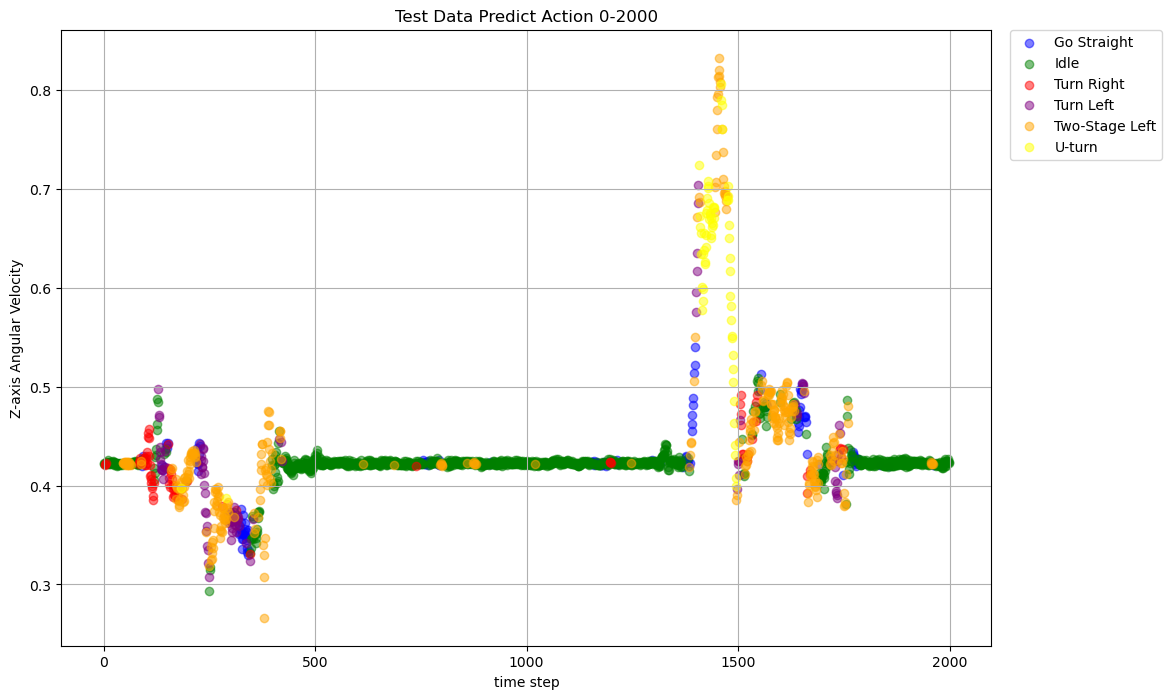

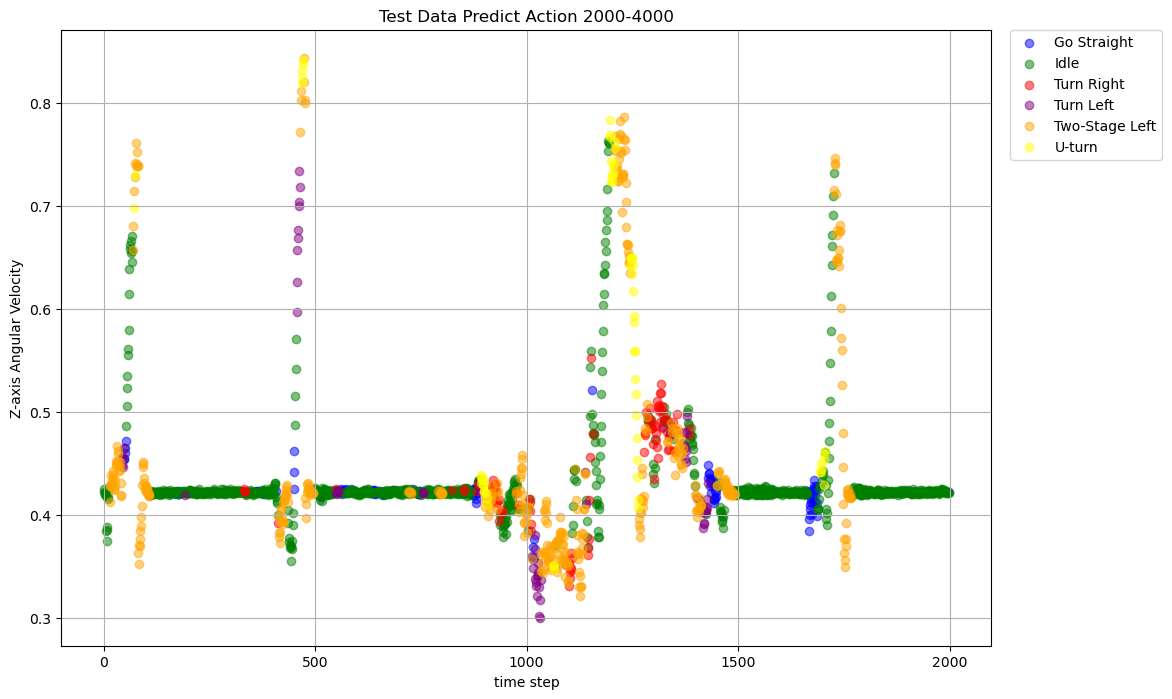

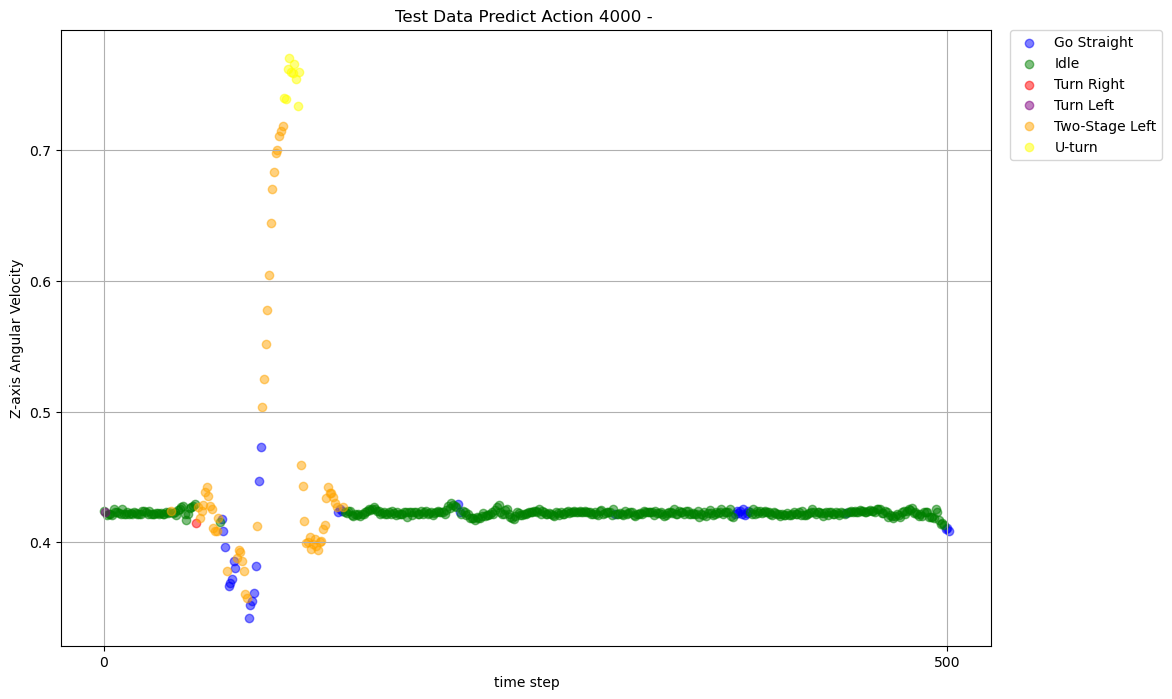

In [12]:
# 以2000時間步為主(因為較好觀察)
Test_Data_1 = Test_Data.iloc[:2000] 
Test_Data_2 = Test_Data.iloc[2000:4000] 
Test_Data_3 = Test_Data.iloc[4000:] 


# 重新設定索引
Test_Data_1.reset_index(drop=True, inplace=True)
Test_Data_2.reset_index(drop=True, inplace=True)
Test_Data_3.reset_index(drop=True, inplace=True)


# 設定顏色映射
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']  #, 'cyan'

# 繪製散點圖
plt.figure(figsize=(12, 8))  # 設定圖形大小

# 逐個狀態繪製散點圖
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn']):
    condition_points = [idx for idx, val in enumerate(Test_Data_1['length = 30']) if val == condition]
    plt.scatter(Test_Data_1.index[condition_points], Test_Data_1['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_1)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 0-2000')  # 設定圖表標題
plt.show()

plt.figure(figsize=(12, 8))  # 設定圖形大小
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn']):
    condition_points = [idx for idx, val in enumerate(Test_Data_2['length = 30']) if val == condition]
    plt.scatter(Test_Data_2.index[condition_points], Test_Data_2['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_1)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 2000-4000')  # 設定圖表標題
plt.show()

plt.figure(figsize=(12, 8))  # 設定圖形大小
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn']):
    condition_points = [idx for idx, val in enumerate(Test_Data_3['length = 30']) if val == condition]
    plt.scatter(Test_Data_3.index[condition_points], Test_Data_3['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_3)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 4000 - ')  # 設定圖表標題
plt.show()


In [13]:
###########################################################################
# 沒有 transition 模型
# 步驟六：
# 使用簡易演算法取眾數去除雜訊
###########################################################################

In [14]:
def filter_actions(data):
    from statistics import mode
    filtered_data = []
    previous_action = None
    for i, action in enumerate(data):
        if action != previous_action:
            window = data[i:i+60]  # 取下60筆資料
            if mode(window) == action:  # 判斷眾數是否與當前資料相同
                pass 
            else:
                if mode(window + data[i-15:i+15]) != action:  # 判斷眾數是否與前一個點的資訊相同    
                    action = mode(window)  # 第一種情況，將當前點更改為眾數
                else:
                    action = previous_action  # 第二種情況，將當前點更改為前一個點的值
        filtered_data.append(action)
        previous_action = action
    return filtered_data


Test_Data['Filtered length = 30'] = filter_actions(Test_Data['length = 30'])

# 先去除未標記資料
Test_Data = Test_Data[['X-axis Angular Velocity', 'Y-axis Angular Velocity', 'Z-axis Angular Velocity', 'X-axis Acceleration', 'Y-axis Acceleration', 'Z-axis Acceleration', 'X-axis Angle', 'Y-axis Angle', 'Z-axis Angle', 'Base Action', 'Action', 'length = 30', 'length = 60', 'length = 90', 'length = 120', 'length = 150', 'Filtered length = 30']].dropna()
column_names = ['length = 30', 'length = 60', 'length = 90', 'length = 120', 'length = 150', 'Filtered length = 30']
match_percentages = []

for column in column_names:
    count = 0
    for x in range(len(Test_Data)):
        if Test_Data['Action'].iloc[x] == Test_Data[column].iloc[x]:
            count += 1
    match_percentage = (count / len(Test_Data)) * 100
    match_percentages.append(match_percentage)

result_df = pd.DataFrame({'Prediction': column_names, 'Match Percentage': match_percentages})
print(result_df)


# 存下來方便觀察(當前資料夾)
Test_Data.to_csv("Test_Data_nontransition_Filtered_L30.csv")

             Prediction  Match Percentage
0           length = 30         57.974234
1           length = 60         57.552199
2           length = 90         56.441582
3          length = 120         53.931586
4          length = 150         51.599289
5  Filtered length = 30         64.526877


In [15]:
###########################################################################
# 使用 transition 模型
# 步驟七：
# 去雜訊後重新視覺化
###########################################################################

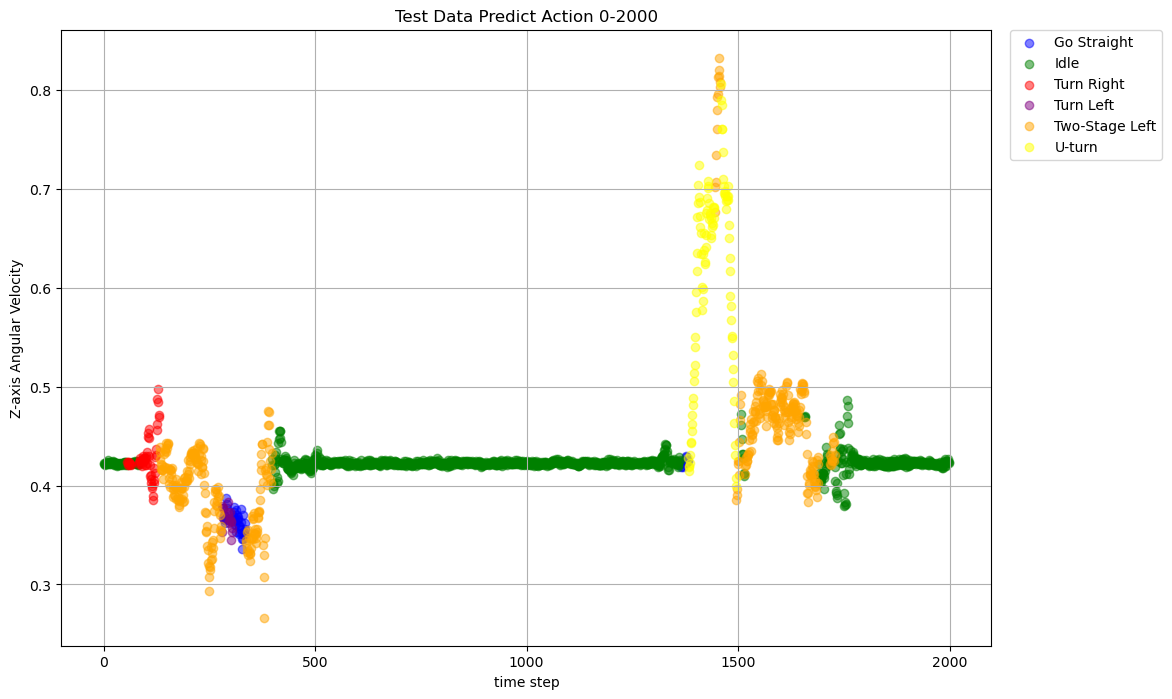

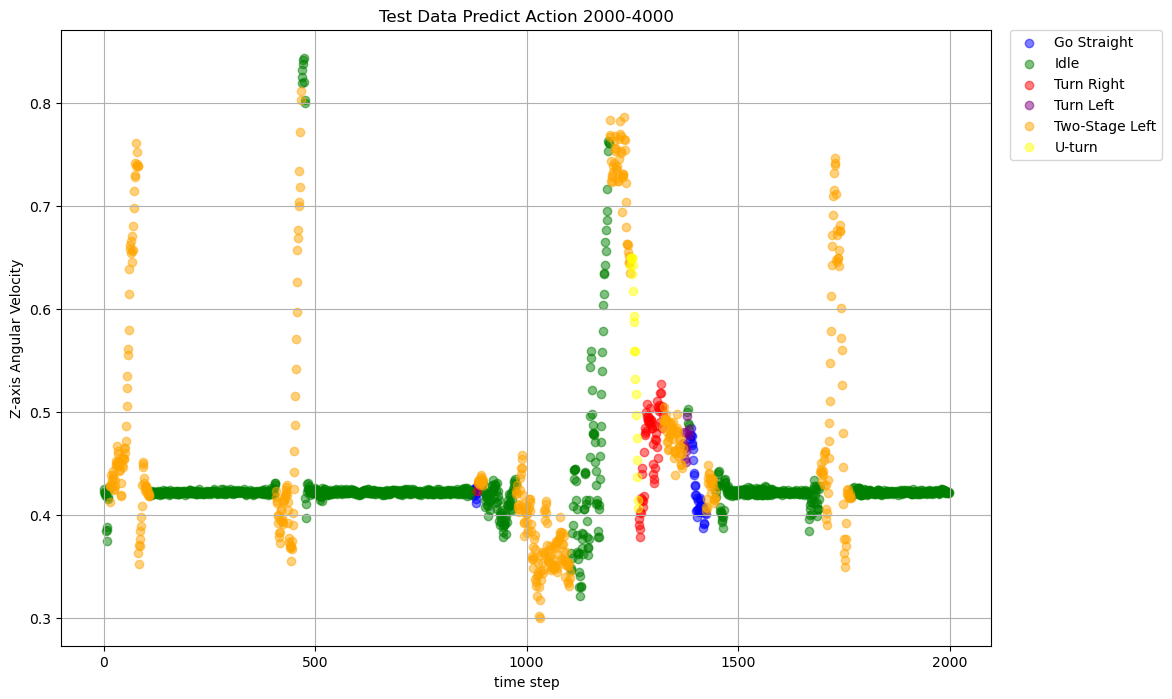

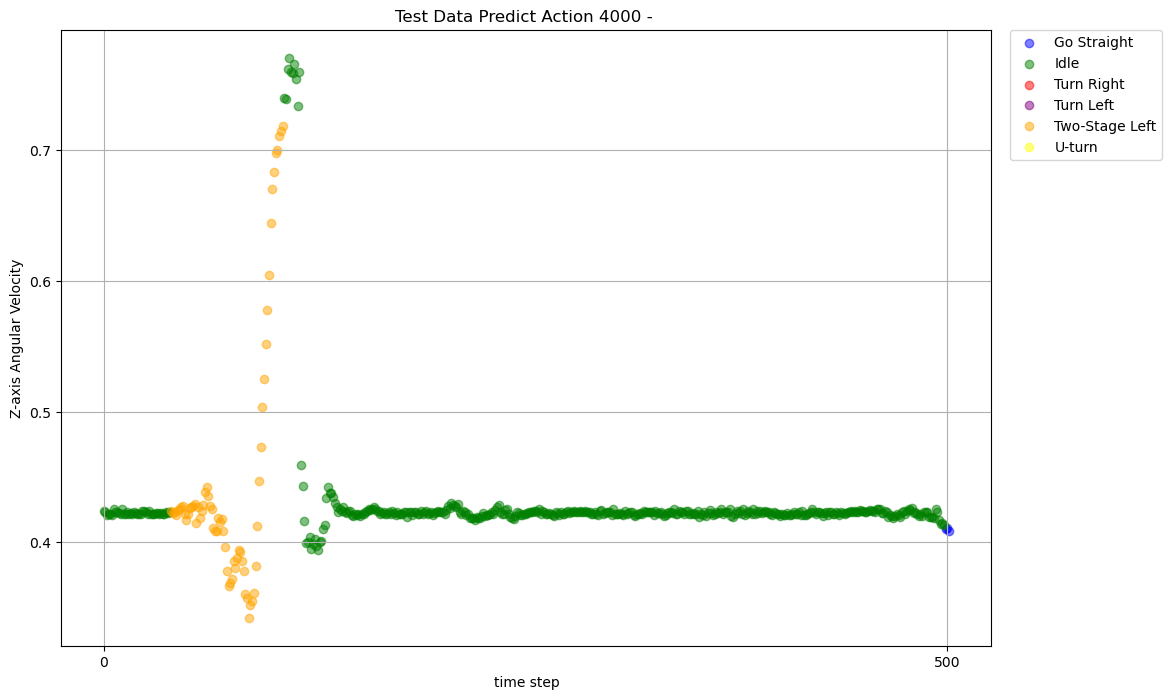

In [16]:
# 以2000時間步為主(因為較好觀察)
Test_Data_1 = Test_Data.iloc[:2000] 
Test_Data_2 = Test_Data.iloc[2000:4000] 
Test_Data_3 = Test_Data.iloc[4000:] 


# 重新設定索引
Test_Data_1.reset_index(drop=True, inplace=True)
Test_Data_2.reset_index(drop=True, inplace=True)
Test_Data_3.reset_index(drop=True, inplace=True)


# 設定顏色映射
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']  #, 'cyan'

# 繪製散點圖
plt.figure(figsize=(12, 8))  # 設定圖形大小

# 逐個狀態繪製散點圖
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn']):
    condition_points = [idx for idx, val in enumerate(Test_Data_1['Filtered length = 30']) if val == condition]
    plt.scatter(Test_Data_1.index[condition_points], Test_Data_1['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_1)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 0-2000')  # 設定圖表標題
plt.show()

plt.figure(figsize=(12, 8))  # 設定圖形大小
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn']):
    condition_points = [idx for idx, val in enumerate(Test_Data_2['Filtered length = 30']) if val == condition]
    plt.scatter(Test_Data_2.index[condition_points], Test_Data_2['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_1)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 2000-4000')  # 設定圖表標題
plt.show()

plt.figure(figsize=(12, 8))  # 設定圖形大小
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn']):
    condition_points = [idx for idx, val in enumerate(Test_Data_3['Filtered length = 30']) if val == condition]
    plt.scatter(Test_Data_3.index[condition_points], Test_Data_3['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_3)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 4000 - ')  # 設定圖表標題
plt.show()


In [17]:
###########################################################################
# 使用 transition 模型
# 步驟一：
# 取資料集(取樣頻率30)，並分成訓練集(80%)與測試集(20%)
###########################################################################

In [18]:
DataSet = pd.read_csv(r"C:\Users\William\Desktop\可愛的論文\Data Set\DataSet_Rotation_submean_Normaliation_transition_4cluster.csv")
DataSet = DataSet.drop('Unnamed: 0', axis=1)
Train_Data = DataSet[:22062]
Test_Data  = DataSet[22062:]


In [19]:
###########################################################################
# 沒有 transition 模型
# 步驟二：
# 提取訓練輸入序列，並做模型訓練
# 此步驟最花時間，故加入執行時間紀錄
###########################################################################

In [20]:
start_time = time.time()


Go_Straight = Train_Data[Train_Data['Action'] == 'Go straight']['Base Action'].values
Go_Straight = [int(x) for x in Go_Straight]
Go_Model = vomm.ppm()
Go_Model.fit(Go_Straight, d=90, alphabet_size=4)



Idle = Train_Data[Train_Data['Action'] == 'Idle']['Base Action'].values
Idle = [int(x) for x in Idle]
Idle_Model = vomm.ppm()
Idle_Model.fit(Idle, d=90, alphabet_size=4)


Turn_Left = Train_Data[Train_Data['Action'] == 'Turn left']['Base Action'].values
Turn_Left = [int(x) for x in Turn_Left]
Left_Model = vomm.ppm()
Left_Model.fit(Turn_Left, d=90, alphabet_size=4)


Turn_Right = Train_Data[Train_Data['Action'] == 'Turn right']['Base Action'].values
Turn_Right = [int(x) for x in Turn_Right]
Right_Model = vomm.ppm()
Right_Model.fit(Turn_Right, d=90, alphabet_size=4)


Two = Train_Data[Train_Data['Action'] == 'Two-stage left turn']['Base Action'].values
Two = [int(x) for x in Two]
Two_Model = vomm.ppm()
Two_Model.fit(Two, d=90, alphabet_size=4)


U = Train_Data[Train_Data['Action'] == 'U-turn']['Base Action'].values
U = [int(x) for x in U]
U_Model = vomm.ppm()
U_Model.fit(U, d=90, alphabet_size=4)

transition = Train_Data[Train_Data['Action'] == 'transition']['Base Action'].values
transition = [int(x) for x in transition]
transition_Model = vomm.ppm()
transition_Model.fit(transition, d=90, alphabet_size=4)


# 計算執行時間
end_time = time.time()
execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = int(execution_time % 60)
print(f"訓練模型所花費時間：{hours}小時{minutes}分鐘{seconds}秒")

訓練模型所花費時間：0小時33分鐘10秒


In [21]:
###########################################################################
# 使用 transition 模型
# 步驟三：
# 提取子序列(參考時間步長 L )做測試集預測
###########################################################################

In [22]:
# 提取子序列(要預測的輸入)
sequence = ''.join(Test_Data['Base Action'].astype(str))

def extract_subsequences(sequence, k):
    subsequences = []
    for i in range(len(sequence)):
        start_index = max(0, i - (k-1))  # k-1考量前k-1步(加當前則為k步)
        subsequence = sequence[start_index:i + 1]  # 提取子序列
        subsequences.append(subsequence)
    return subsequences

subsequence_30  = extract_subsequences(sequence, 30)    # 參考時間步長 L=30  (約為1秒)
subsequence_60  = extract_subsequences(sequence, 60)    # 參考時間步長 L=60  (約為2秒)
subsequence_90  = extract_subsequences(sequence, 90)    # 參考時間步長 L=90  (約為3秒)
subsequence_120 = extract_subsequences(sequence, 120)  # 參考時間步長 L=120 (約為4秒)
subsequence_150 = extract_subsequences(sequence, 150)  # 參考時間步長 L=150 (約為5秒)


# 開始預測
def predict(subsequence):
    predictions=[]
    for data in subsequence:
        Max_Score = float('-inf')
        Selected_Model = None
        data = [int(x) for x in data]
        Idle_Model_Score = Idle_Model.logpdf(data)
        Go_Model_Score = Go_Model.logpdf(data)
        Left_Model_Score = Left_Model.logpdf(data)
        Right_Model_Score = Right_Model.logpdf(data)
        Two_Model_Score = Two_Model.logpdf(data)
        U_Model_Score = U_Model.logpdf(data)
        transition_Score = transition_Model.logpdf(data)
        Score_Models = [Idle_Model_Score, Go_Model_Score, Left_Model_Score, Right_Model_Score, Two_Model_Score, U_Model_Score, transition_Score]    
        Models = ['Idle', 'Go Straight','Turn Left', 'Turn Right', 'Two-Stage Left', 'U-turn', 'transition']    
        for Score, model in zip(Score_Models, Models):
            if Score > Max_Score:
                Max_Score = Score
                Selected_Model = model
        predictions.append(Selected_Model)
    return predictions

predictions_30  = predict(subsequence_30)
predictions_60  = predict(subsequence_60)
predictions_90  = predict(subsequence_90) 
predictions_120 = predict(subsequence_120)
predictions_150 = predict(subsequence_150)


# 將預測結果加入 Test Data (方便觀察)

Test_Data['length = 30'] = predictions_30
Test_Data['length = 60']  = predictions_60
Test_Data['length = 90']  = predictions_90
Test_Data['length = 120'] = predictions_120
Test_Data['length = 150'] = predictions_150
Test_Data.to_csv(r'C:\Users\William\Desktop\可愛的論文\Data Set\TestData_transition_4cluster_predict.csv')

C:\Users\William\AppData\Local\Temp\ipykernel_12072\382386412.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test_Data['length = 30'] = predictions_30
C:\Users\William\AppData\Local\Temp\ipykernel_12072\382386412.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test_Data['length = 60']  = predictions_60
C:\Users\William\AppData\Local\Temp\ipykernel_12072\382386412.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [23]:
###########################################################################
# 沒有 transition 模型
# 步驟四：
# 與有人工標記的做比較確認準確度
###########################################################################

In [24]:
# 先去除未標記資料
Test_Data = Test_Data[['X-axis Angular Velocity', 'Y-axis Angular Velocity', 'Z-axis Angular Velocity', 'X-axis Acceleration', 'Y-axis Acceleration', 'Z-axis Acceleration', 'X-axis Angle', 'Y-axis Angle', 'Z-axis Angle', 'Base Action', 'Action', 'length = 30', 'length = 60', 'length = 90', 'length = 120', 'length = 150']].dropna()
column_names = ['length = 30', 'length = 60', 'length = 90', 'length = 120', 'length = 150']
match_percentages = []

for column in column_names:
    count = 0
    for x in range(len(Test_Data)):
        if Test_Data['Action'].iloc[x] == Test_Data[column].iloc[x]:
            count += 1
    match_percentage = (count / len(Test_Data)) * 100
    match_percentages.append(match_percentage)

result_df = pd.DataFrame({'Prediction': column_names, 'Match Percentage': match_percentages})
print(result_df)

     Prediction  Match Percentage
0   length = 30         49.279161
1   length = 60         48.062161
2   length = 90         47.406853
3  length = 120         45.646883
4  length = 150         43.475005


In [25]:
###########################################################################
# 沒有 transition 模型
# 步驟五：
# 將序列動作視覺化
###########################################################################

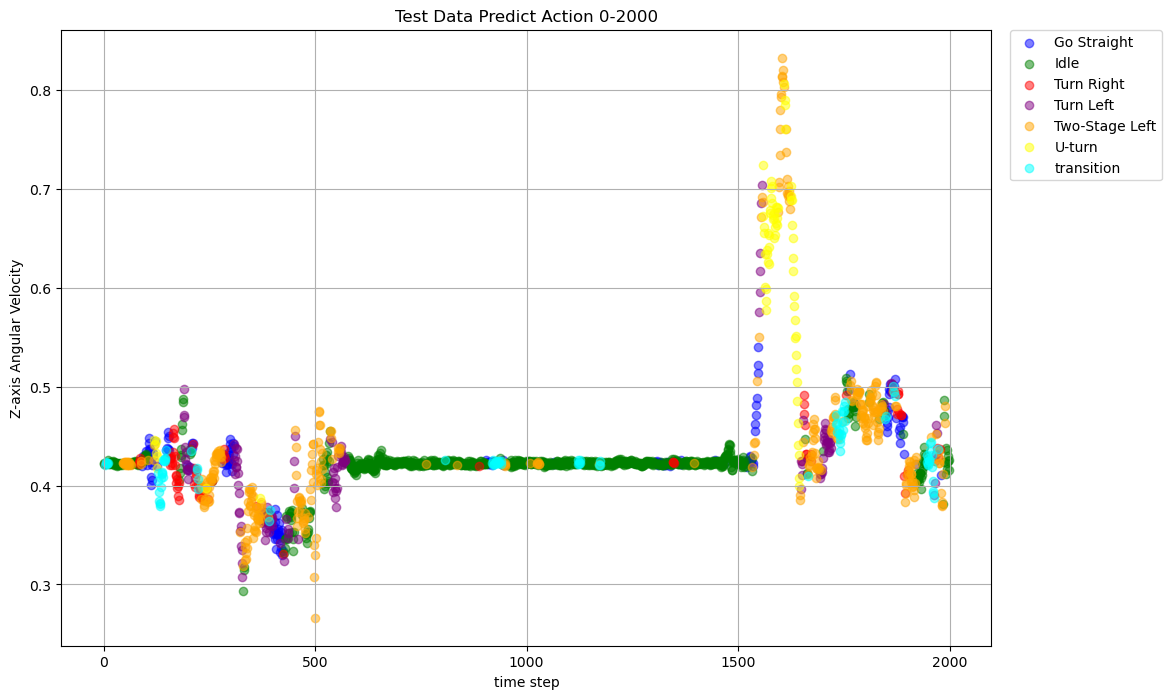

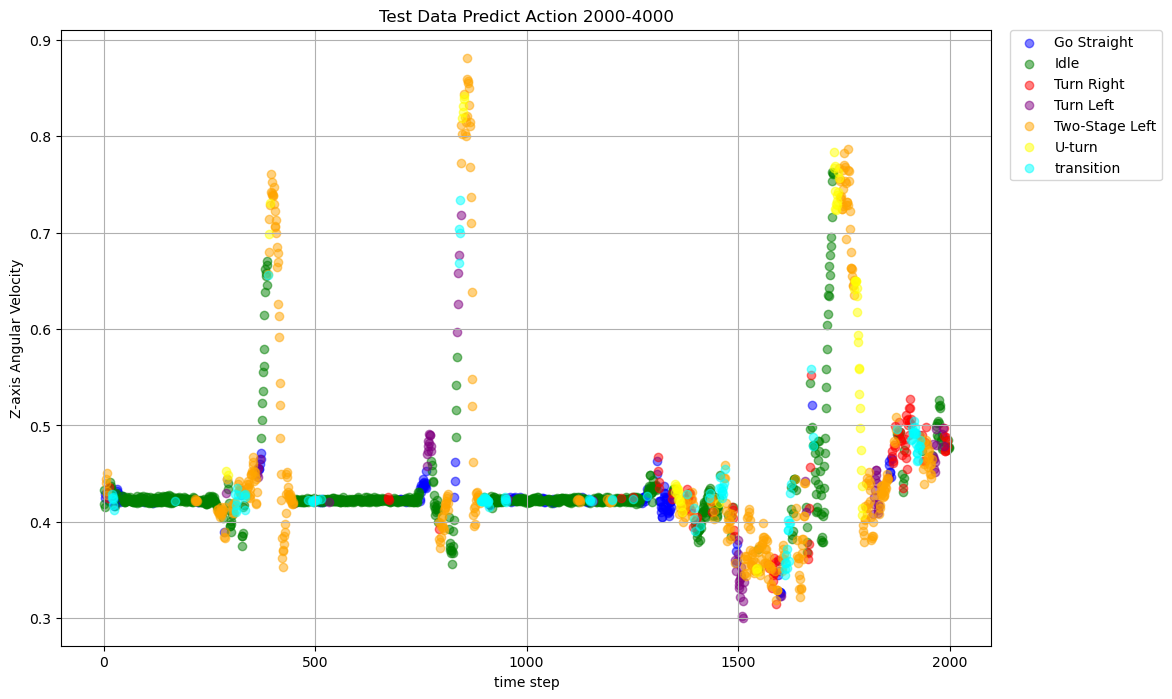

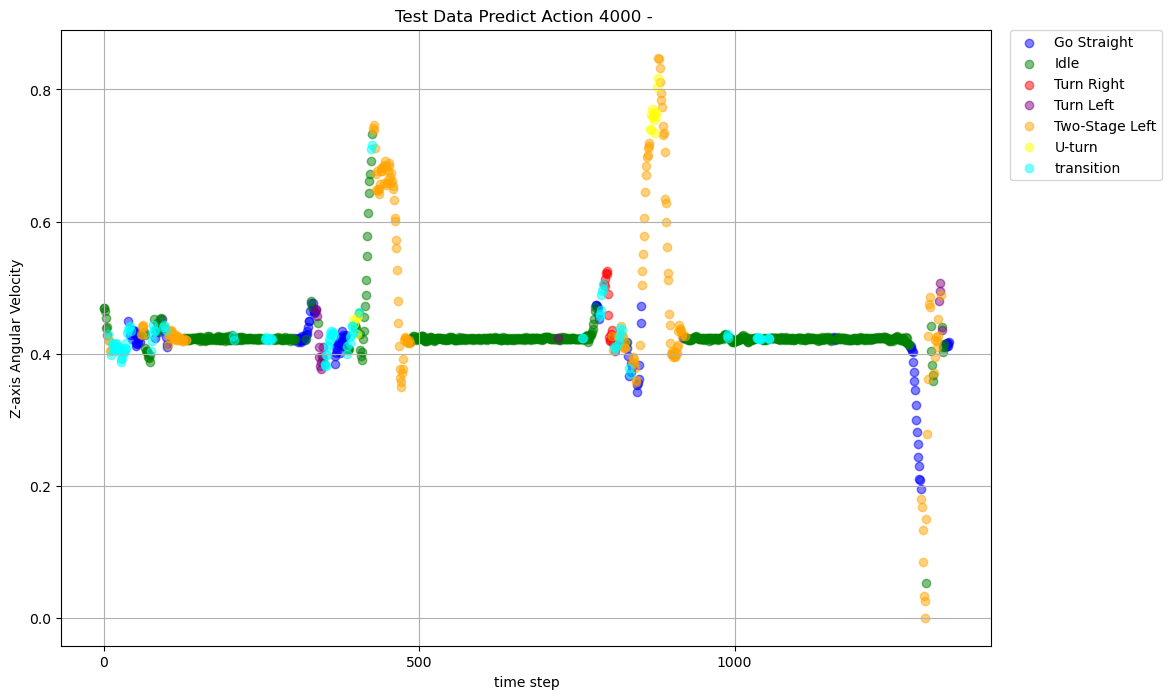

In [26]:
# 以2000時間步為主(因為較好觀察)
Test_Data_1 = Test_Data.iloc[:2000] 
Test_Data_2 = Test_Data.iloc[2000:4000] 
Test_Data_3 = Test_Data.iloc[4000:] 


# 重新設定索引
Test_Data_1.reset_index(drop=True, inplace=True)
Test_Data_2.reset_index(drop=True, inplace=True)
Test_Data_3.reset_index(drop=True, inplace=True)


# 設定顏色映射
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'cyan'] 

# 繪製散點圖
plt.figure(figsize=(12, 8))  # 設定圖形大小

# 逐個狀態繪製散點圖
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn', 'transition']):
    condition_points = [idx for idx, val in enumerate(Test_Data_1['length = 30']) if val == condition]
    plt.scatter(Test_Data_1.index[condition_points], Test_Data_1['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_1)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 0-2000')  # 設定圖表標題
plt.show()

plt.figure(figsize=(12, 8))  # 設定圖形大小
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn', 'transition']):
    condition_points = [idx for idx, val in enumerate(Test_Data_2['length = 30']) if val == condition]
    plt.scatter(Test_Data_2.index[condition_points], Test_Data_2['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_1)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 2000-4000')  # 設定圖表標題
plt.show()

plt.figure(figsize=(12, 8))  # 設定圖形大小
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn', 'transition']):
    condition_points = [idx for idx, val in enumerate(Test_Data_3['length = 30']) if val == condition]
    plt.scatter(Test_Data_3.index[condition_points], Test_Data_3['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_3)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 4000 - ')  # 設定圖表標題
plt.show()


In [27]:
###########################################################################
# 沒有 transition 模型
# 步驟六：
# 使用簡易演算法取眾數去除雜訊
###########################################################################

In [28]:
def filter_actions(data):
    from statistics import mode
    filtered_data = []
    previous_action = None
    for i, action in enumerate(data):
        if action != previous_action:
            window = data[i:i+60]  # 取下60筆資料
            if mode(window) == action:  # 判斷眾數是否與當前資料相同
                pass 
            else:
                if mode(window + data[i-15:i+15]) != action:  # 判斷眾數是否與前一個點的資訊相同    
                    action = mode(window)  # 第一種情況，將當前點更改為眾數
                else:
                    action = previous_action  # 第二種情況，將當前點更改為前一個點的值
        filtered_data.append(action)
        previous_action = action
    return filtered_data


Test_Data['Filtered length = 30'] = filter_actions(Test_Data['length = 30'])

# 先去除未標記資料
Test_Data = Test_Data[['X-axis Angular Velocity', 'Y-axis Angular Velocity', 'Z-axis Angular Velocity', 'X-axis Acceleration', 'Y-axis Acceleration', 'Z-axis Acceleration', 'X-axis Angle', 'Y-axis Angle', 'Z-axis Angle', 'Base Action', 'Action', 'length = 30', 'length = 60', 'length = 90', 'length = 120', 'length = 150', 'Filtered length = 30']].dropna()
column_names = ['length = 30', 'length = 60', 'length = 90', 'length = 120', 'length = 150', 'Filtered length = 30']
match_percentages = []

for column in column_names:
    count = 0
    for x in range(len(Test_Data)):
        if Test_Data['Action'].iloc[x] == Test_Data[column].iloc[x]:
            count += 1
    match_percentage = (count / len(Test_Data)) * 100
    match_percentages.append(match_percentage)

result_df = pd.DataFrame({'Prediction': column_names, 'Match Percentage': match_percentages})
print(result_df)

# 存下來方便觀察(當前資料夾)
Test_Data.to_csv("Test_Data_nontransition_Filtered_L30.csv")

             Prediction  Match Percentage
0           length = 30         49.279161
1           length = 60         48.062161
2           length = 90         47.406853
3          length = 120         45.646883
4          length = 150         43.475005
5  Filtered length = 30         54.802471


In [29]:
###########################################################################
# 使用 transition 模型
# 步驟七：
# 去雜訊後重新視覺化
###########################################################################

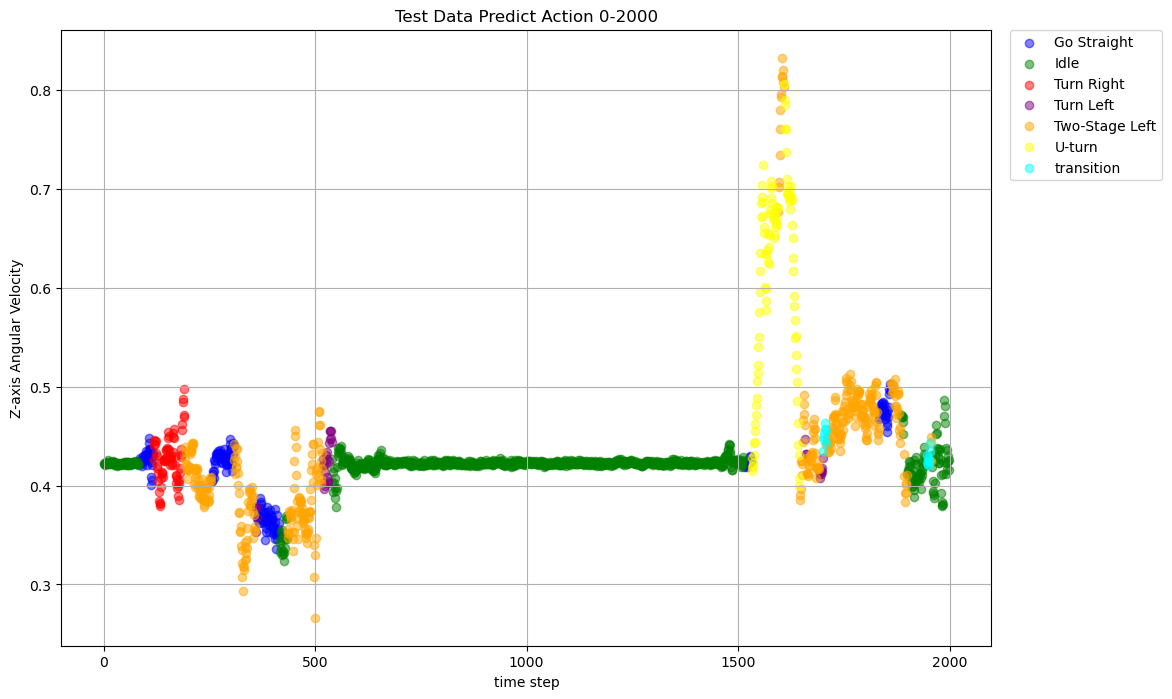

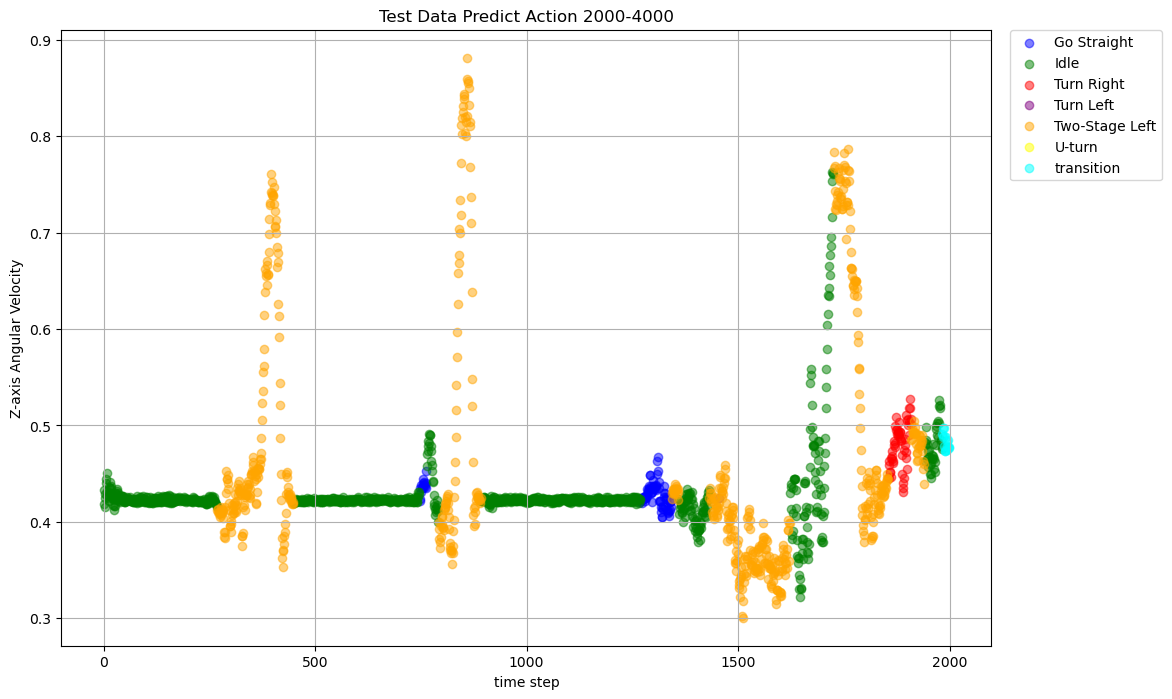

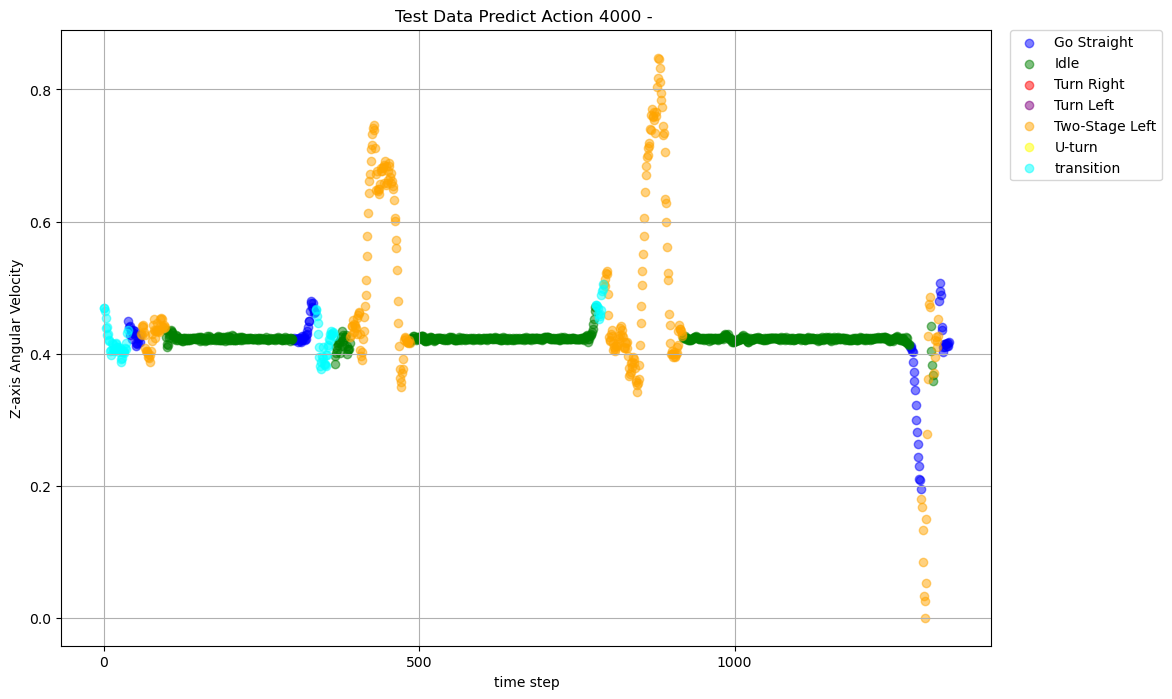

In [30]:
# 以2000時間步為主(因為較好觀察)
Test_Data_1 = Test_Data.iloc[:2000] 
Test_Data_2 = Test_Data.iloc[2000:4000] 
Test_Data_3 = Test_Data.iloc[4000:] 


# 重新設定索引
Test_Data_1.reset_index(drop=True, inplace=True)
Test_Data_2.reset_index(drop=True, inplace=True)
Test_Data_3.reset_index(drop=True, inplace=True)


# 設定顏色映射
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'cyan'] 

# 繪製散點圖
plt.figure(figsize=(12, 8))  # 設定圖形大小

# 逐個狀態繪製散點圖
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn', 'transition']):
    condition_points = [idx for idx, val in enumerate(Test_Data_1['Filtered length = 30']) if val == condition]
    plt.scatter(Test_Data_1.index[condition_points], Test_Data_1['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_1)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 0-2000')  # 設定圖表標題
plt.show()

plt.figure(figsize=(12, 8))  # 設定圖形大小
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn', 'transition']):
    condition_points = [idx for idx, val in enumerate(Test_Data_2['Filtered length = 30']) if val == condition]
    plt.scatter(Test_Data_2.index[condition_points], Test_Data_2['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_1)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 2000-4000')  # 設定圖表標題
plt.show()

plt.figure(figsize=(12, 8))  # 設定圖形大小
for i, condition in enumerate(['Go Straight', 'Idle', 'Turn Right', 'Turn Left', 'Two-Stage Left', 'U-turn', 'transition']):
    condition_points = [idx for idx, val in enumerate(Test_Data_3['Filtered length = 30']) if val == condition]
    plt.scatter(Test_Data_3.index[condition_points], Test_Data_3['Z-axis Angular Velocity'][condition_points], color=colors[i], label=condition, alpha=0.5)

plt.xlabel('time step')  # 設定X軸標籤
plt.ylabel('Z-axis Angular Velocity')  # 設定Y軸標籤
plt.xticks(range(0, len(Test_Data_3)+1, 500))  # 設定X軸刻度
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)  # 將圖例移至圖外
plt.grid(True)  # 顯示網格
plt.title('Test Data Predict Action 4000 - ')  # 設定圖表標題
plt.show()
